In [46]:
%matplotlib inline
import numpy as np
from astropy.io import fits as pf
import matplotlib
from matplotlib import pyplot as plt
import scipy.interpolate as sciinterp
import scipy

In [47]:
def openFile(filename):
    
    """Given the filename of a fits file extracts the data.
       Works on both flux and wavlength solution files."""
    
    file = pf.open(filename)
    
    return file[0].data

In [48]:
def newBins(order_wave_values, sample_rate = 1):
    
    """Calculates equally spaced wavlength bins that span the
       same total wavelength as the given bins."""
    
    new_bins = np.linspace(min(order_wave_values), max(order_wave_values), len(order_wave_values)*sample_rate)
    
    return new_bins

In [49]:
def interpolate(new_bins, order_wave_values, flux):
    
    """Uses the numpy interpolation function to extract values
       for flux correspondingn to new wavelength bins."""
    
    new_flux = np.interp(new_bins, order_wave_values, flux)
    
    return new_flux

In [50]:
def sciinterpolate(new_bins, old_bins, old_flux, method = "linear"):
    
    interpfunc = sciinterp.interp1d(old_bins, old_flux, kind = method)
    new_flux = interpfunc(new_bins)
    
    return new_flux

In [51]:
def rms2Spectra(spec1, spec2):
    assert len(spec1) == len(spec2)
    diff = np.array([])
    for fluxval in range(len(spec1)):
        diff = np.append(diff, spec1[fluxval] - spec2[fluxval])
    diffsquares = diff**2
    sumsquares = np.sum(diffsquares)
    normed = sumsquares/(len(spec1) - 1)
    return normed**(0.5)

In [52]:
flux1 = openFile("rarp.210.fits")[25]

In [53]:
flux2 = openFile("rbdl.232.fits")[25]

In [54]:
wavelength = openFile("apf_wave_mod.fits")[25]

In [55]:
baseRMS = rms2Spectra(flux1, flux2)
baseRMS

1410.8994142433041

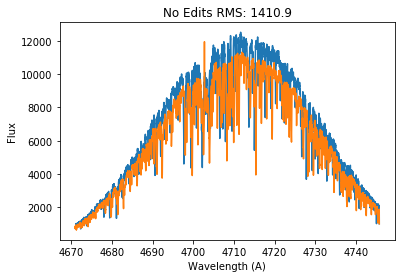

In [56]:
plt.plot(wavelength, flux1)
plt.plot(wavelength, flux2)
plt.title("No Edits RMS: " + str(np.round(baseRMS, 1)))
plt.xlabel("Wavelength (A)")
plt.ylabel("Flux")
plt.show()

## Blaze function removal

In [57]:
#normalize 
def normalize(x, y):
    wavelength_range = max(x) - min(x)
    wave_center = x - min(x) - wavelength_range/2.
    norm_spectrum = y/max(y)
    return wave_center, norm_spectrum

In [58]:
wave_center1, norm_spectrum1 = normalize(wavelength, flux1)
wave_center2, norm_spectrum2 = normalize(wavelength, flux2)

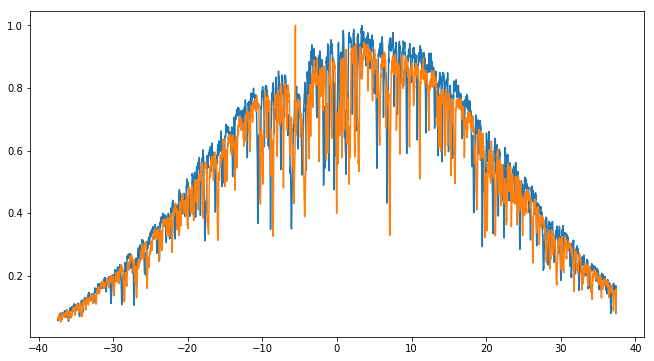

In [59]:
plt.figure(figsize = (11,6))
plt.plot(wave_center1, norm_spectrum1)
plt.plot(wave_center2, norm_spectrum2)

In [60]:
def sectionAndAverage(wavelengths, flux, sections):
    flux_blocks = np.array_split(flux, sections)
    averages = np.array([])
    for section in flux_blocks:
        percentile95 = np.percentile(section, 95)
        lessthan95th = section[section < percentile95]
        sectionavg = np.average(lessthan95th)
        averages = np.append(averages, sectionavg)
    wavesections = np.array_split(wavelengths, sections)
    points = np.array([])
    for section in wavesections:
        section_point = section[int(len(section)/2)]
        points = np.append(points, section_point)
    return points, averages

In [61]:
sections = 6
points, averages = sectionAndAverage(wave_center1, norm_spectrum1, sections)
averages

array([ 0.19349867,  0.58226901,  0.78892517,  0.82009584,  0.51357716,
        0.23927088])

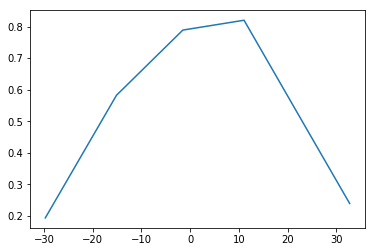

In [62]:
plt.plot(points, averages)
plt.show()

In [63]:
def quadfit(x, a, b, c):
    return a*x**2 + b*x + c

In [64]:
vals, cov = scipy.optimize.curve_fit(quadfit, points, averages)
vals

array([ -6.14623354e-04,   2.77290941e-03,   8.02286771e-01])

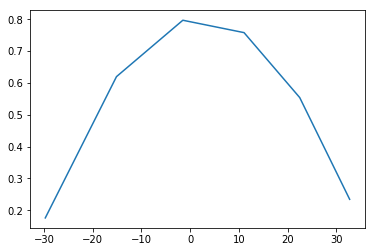

In [65]:
plt.plot(points, quadfit(points, *vals))
plt.show()

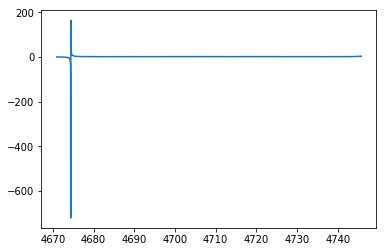

In [66]:
plt.plot(wavelength, norm_spectrum1/quadfit(wave_center1, *vals))

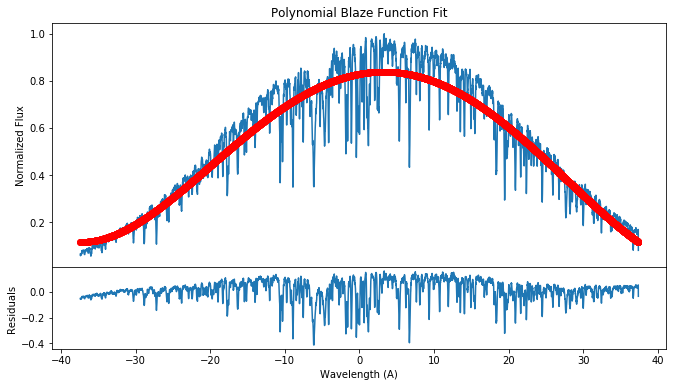

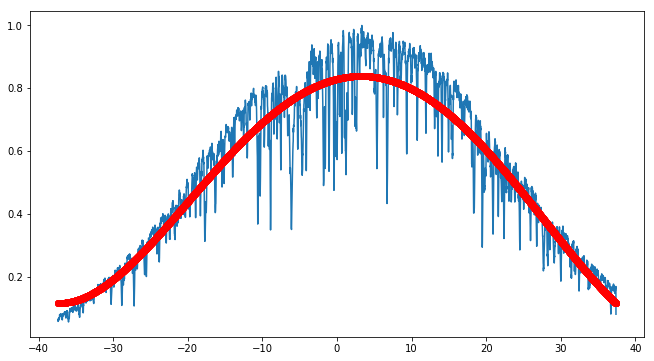

In [91]:
coef = np.polyfit(points, averages, 4)
curve_fit = np.poly1d(coef)
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
ax1 = axs[0]
ax1.plot(wave_center1, norm_spectrum1)
ax1.plot(wave_center1, curve_fit(wave_center1), "ro")
ax1.title.set_text("Polynomial Blaze Function Fit")
ax1.set_ylabel("Normalized Flux")
ax2 = axs[1]
ax2.plot(wave_center1, norm_spectrum1 - curve_fit(wave_center1))
ax2.set_ylabel("Residuals")
plt.xlabel("Wavelength (A)")
plt.show()
plt.figure(figsize = (11,6))
plt.plot(wave_center1, norm_spectrum1)
plt.plot(wave_center1, curve_fit(wave_center1), "ro")

In [68]:
polyfitRMS = rms2Spectra(norm_spectrum1, curve_fit(wave_center1))
polyfitRMS

0.094124755221899573

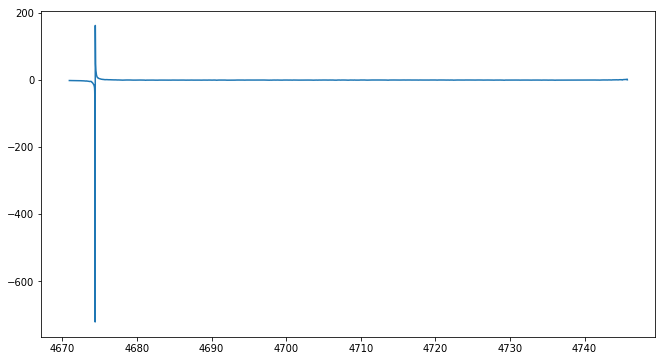

In [69]:
plt.figure(figsize = (11,6))
plt.plot(wavelength, norm_spectrum1/curve_fit(wave_center1))

In [70]:
def removeBlaze(wavelength, flux, sections, polydegree):
    wave_center, norm_spectrum = normalize(wavelength, flux)
    points, averages = sectionAndAverage(wave_center, norm_spectrum, sections)
    coef = np.polyfit(points, averages, polydegree)
    curve_fit = np.poly1d(coef)
    return norm_spectrum/curve_fit(wave_center)

In [71]:
flux1NB = removeBlaze(wavelength, flux1, 6, 2)
flux2NB = removeBlaze(wavelength, flux2, 6, 2)

In [72]:
rmsNB = rms2Spectra(flux1NB, flux2NB)

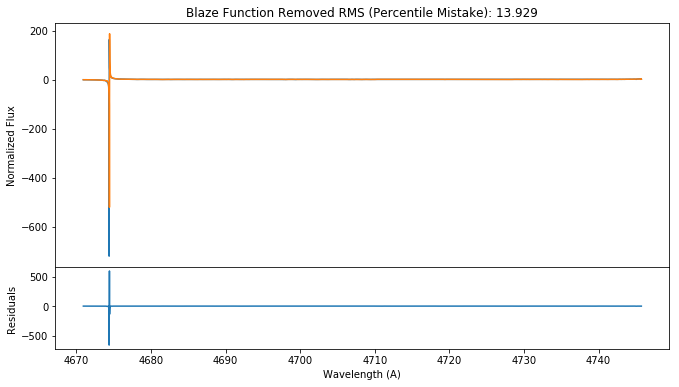

In [73]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
ax1 = axs[0]
ax1.plot(wavelength, flux1NB)
ax1.plot(wavelength, flux2NB)
ax1.title.set_text("Blaze Function Removed RMS (Percentile Mistake): " + str(np.round(rmsNB, 3)))
ax1.set_ylabel("Normalized Flux")
ax2 = axs[1]
ax2.plot(wavelength, flux1NB - flux2NB)
ax2.set_ylabel("Residuals")
plt.xlabel("Wavelength (A)")
plt.show()

Text(0,0.5,'Normalized Flux')

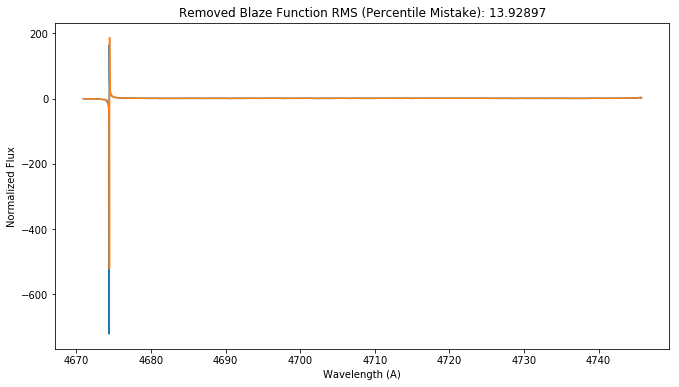

In [74]:
plt.figure(figsize = (11,6))
plt.plot(wavelength, flux1NB)
plt.plot(wavelength, flux2NB)
plt.title("Removed Blaze Function RMS (Percentile Mistake): " + str(np.round(rmsNB, 5)))
plt.xlabel("Wavelength (A)")
plt.ylabel("Normalized Flux")

## Shifting and RMS calculation

When calculating RMS, do not include flux values on either side equal to the shift amount (shift to the right 1 unit, do not include first or last elements in array in RMS calculation.)

In [75]:
maxshift = 200
allRMS = np.array([])
shiftVals = np.array([])
for i in range(-maxshift, maxshift + 1):
    #make a copy of the flux so rolling does
    #not affect original data
    copyflux1 = np.copy(flux1NB)
    copyflux2 = np.copy(flux2NB)
    #shift flux by i
    copyflux2 = np.roll(copyflux2, i)
    #truncate flux arrays
    copyflux1 = copyflux1[abs(i):len(copyflux1) - abs(i)]
    copyflux2 = copyflux2[abs(i):len(copyflux2) - abs(i)]
    #calculate new rms
    shiftRMS = rms2Spectra(copyflux1, copyflux2)
    #store RMS value
    allRMS = np.append(allRMS, shiftRMS)
    #store shift value for the rms
    shiftVals = np.append(shiftVals, i)

In [76]:
index = np.argmin(allRMS)
index

0

In [77]:
shiftVals[179]

-21.0

In [78]:
print(allRMS)

[  0.39525078   0.40071841   0.40557507   0.4115315    0.41762177
   0.42390772   0.4313687    0.4403478    0.44901477   0.45930507
   0.47171406   0.48504066   0.49933039   0.51432236   0.53101345
   0.54954353   0.57200383   0.59961111   0.63052996   0.66879682
   0.71683493   0.77637316   0.85833949   0.9587459    1.09832137
   1.32404809   1.74976865   3.04360289  11.47185595  11.58204317
  11.61294091  11.61979436  11.62411901  11.62663796  11.62747638
  11.62810091  11.62787127  11.62722184  11.62735478  11.62562148
  11.62392986  11.62308882  11.62216237  11.62088676  11.61934602
  11.61615341  11.61431306  11.61280694  11.61049452  11.60835206
  11.60591643  11.60406941  11.60104989  11.59880916  11.59568115
  11.59375676  11.59145802  11.58858336  11.58740071  11.58401151
  11.58232988  11.57910221  11.57793979  11.5747129   11.572181
  11.57085853  11.56903533  11.5667634   11.5650452   11.56408968
  11.56087301  11.55775809  11.55454343  11.55316608  11.55081163
  11.5477706

In [79]:
allRMS[179]

14.233851604988873

In [80]:
minrms = rms2Spectra(flux1NB[21:len(flux1NB) - 21], np.roll(flux2NB, - 21)[21: len(flux2NB) - 21])

In [81]:
minrms

14.233851604988873

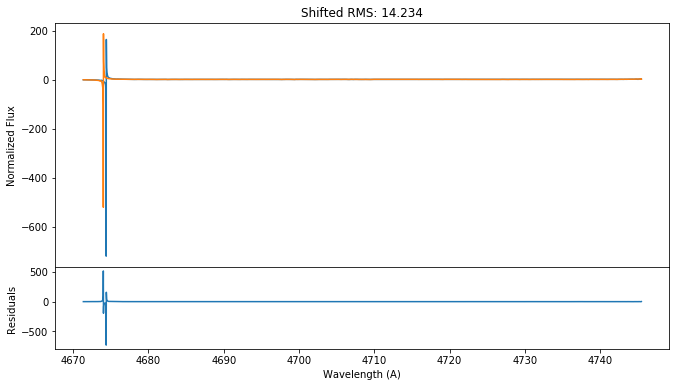

In [82]:
truncwave = wavelength[21: len(wavelength) - 21]
truncflux1 = flux1NB[21: len(flux1NB) - 21]
truncflux2 = np.roll(flux2NB, - 21)[21: len(flux2NB) - 21]
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
ax1 = axs[0]
ax1.plot(truncwave, truncflux1)
ax1.plot(truncwave, truncflux2)
ax1.title.set_text("Shifted RMS: " + str(np.round(minrms, 3)))
ax1.set_ylabel("Normalized Flux")
ax2 = axs[1]
ax2.plot(truncwave, truncflux1 - truncflux2)
ax2.set_ylabel("Residuals")
plt.xlabel("Wavelength (A)")
plt.show()

In [83]:
flux4 = openFile("rarp.210.fits")[55]

In [84]:
flux5 = openFile("rbdl.232.fits")[55]

In [85]:
wavelength2 = openFile("apf_wave_mod.fits")[55]

In [86]:
flux4NB = removeBlaze(wavelength2, flux4, 6, 2)
flux5NB = removeBlaze(wavelength2, flux5, 6, 2)

In [87]:
rmsNB2 = rms2Spectra(flux4NB, flux5NB)

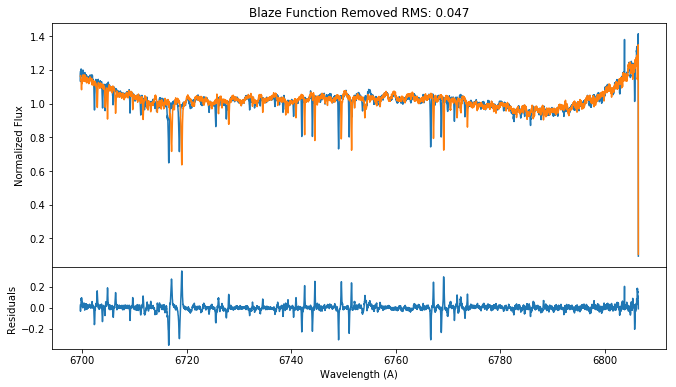

In [88]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[3, 1]}, figsize = (11, 6))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
ax1 = axs[0]
ax1.plot(wavelength2, flux4NB)
ax1.plot(wavelength2, flux5NB)
ax1.title.set_text("Blaze Function Removed RMS: " + str(np.round(rmsNB2, 3)))
ax1.set_ylabel("Normalized Flux")
ax2 = axs[1]
ax2.plot(wavelength2, flux4NB - flux5NB)
ax2.set_ylabel("Residuals")
plt.xlabel("Wavelength (A)")
plt.show()

## Determining Max/Min possible value of shift

In [89]:
differences = np.diff(wavelength)
maxdiff = max(differences)
mindiff = min(differences)

In [90]:
deltawav/wav = v/c

SyntaxError: can't assign to operator (<ipython-input-90-f6760ee5dd5d>, line 1)

In [ ]:
v = c*deltawav/wav